# *svoboda lab / tactile navigation*

## Setup evnironment

In [4]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import json
import re
from scipy.stats import f_oneway
from scipy.interpolate import UnivariateSpline
from helper.plots import *
save = False

## Setup plotting

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

## Load raw data

In [7]:
path = os.path.expanduser('~/Dropbox/paper.tuning')

In [8]:
iSession = 13
session = '%02g' % iSession

#### Load info

In [9]:
with open(os.path.join(path,'data',session,'info.json')) as infile:
    info = json.load(infile)
info['contributors'] = ', '.join(info['contributors'])
info['dimensions'] = str(info['dimensions'])
info = pd.DataFrame(info, index = [str(info['id'])])

#### Load params

In [10]:
covariates = pd.DataFrame.from_csv(os.path.join(path,'data',session,'params','covariates.csv'))

Summarize trial information

In [11]:
trialData = covariates[['trialType','trialNum']].groupby(['trialNum'], sort=True).first()
trialData = trialData.join(covariates[['speed','trialNum','corPos']].groupby(['trialNum'], sort=True).mean())
trialData.sort('trialType', inplace = True, ascending = False)

In [12]:
speedThresh = 3

####Load timeseries

In [13]:
timeseries = pd.DataFrame.from_csv(os.path.join(path,'data',session,'sources','timeseries.csv'))

#### Summarize units

In [14]:
units = pd.DataFrame(timeseries.quantile(q=0.9, axis=1),columns=['activity'])

## Perform regression on timeseries

In [15]:
def getTuningImaging(sourceId,keepInd,name,scale):
    tmp = covariates
    tmp['dff'] = timeseries.loc[sourceId]
    tmp = tmp[keepInd]
    tmp = tmp[~tmp['itiPeriod'].values.astype(bool)]
    tmp[name] = (tmp[name]/scale).round()*scale
    df = tmp[['trialNum',name,'dff']]    
    tuning, p = getTuning(df,'trialNum',name,'dff',sourceId)
    return tuning, p

In [16]:
def getTuning(df,T,X,Y,sourceId):
    df = df.groupby([T,X]).mean()
    df = df.reset_index().set_index(T)
    g = [df[df[X] == x][Y].values for x in df[X].unique()]
    f, p = f_oneway(*g)
    s = df.groupby([X])
    d = {'meanRate':s.mean()[Y].values,'stdRate':s.std()[Y].values,'numTrials':s.count().values[:,0]}
    tuning = pd.DataFrame(d).T
    tuning.columns = s.mean().index.values
    tuning['sourceId'] = sourceId
    tuning.reset_index(level=0, inplace=True)
    tuning.set_index('sourceId', inplace=True)
    tuning.rename(columns={'index':'label'}, inplace=True)
    tuning.index.name = None
    return tuning, p

In [17]:
pattern = re.compile('OL_.*R|OL_out')
indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
indexRun = trialData.speed > speedThresh
trials = trialData[indexOL & indexRun]
keepInd = [x in trials.index for x in covariates.trialNum.values]
tuning = [getTuningImaging(x,keepInd,'corPos',3) for x in range(len(timeseries))]
units['pVal'] = [x[1] for x in tuning]
tuning = pd.concat([x[0] for x in tuning])

## Save summary tables

In [ ]:
if save:
    units.to_csv(os.path.join(path,'data',session,'tables','units.csv'))
    tuning.to_csv(os.path.join(path,'data',session,'tables','tuning.csv'))

# Plot traces

In [18]:
def plotTimeseries(x, start, stop, c, ylabel=None):
    plt.plot((covariates.index[start:stop] - covariates.index[start])/info.iloc[0]['rate-hz'], x[start:stop], c=c);
    plt.xlabel('Time (s)')
    if ylabel:
        plt.ylabel(ylabel)

Define time interval

In [19]:
start = 2664
stop = 3104

Plot wall distance trace

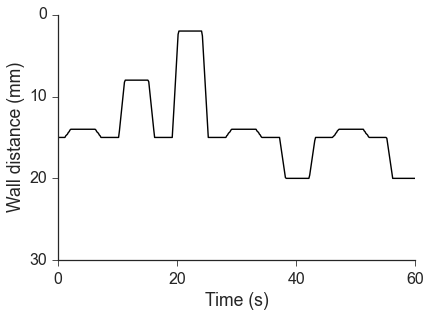

In [20]:
plotTimeseries(covariates.corPos, start, stop, c='k', ylabel='Wall distance (mm)')
plt.xlim([0, 60])
plt.ylim([0, 30])
plt.xticks(range(0,80,20))
plt.yticks(range(0,40,10))
plt.gca().invert_yaxis()
sns.despine()

Sources used in the paper are 150, 159, and 160

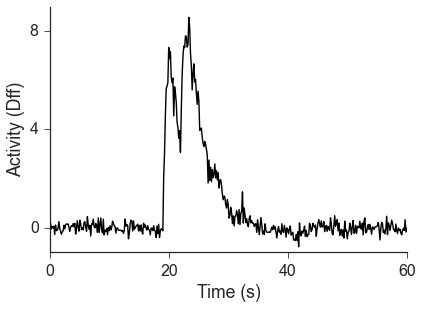

In [21]:
s = 150
plotTimeseries(timeseries.loc[s], start, stop, c='k', ylabel='Activity (Dff)')
plt.xlim([0, 60])
plt.xticks(range(0,80,20))
plt.yticks(range(0,10,4))
plt.ylim([-1, 9])
sns.despine()